# Hypotheses Testing Project with data from the Northwind database


### Importing libraries and connecting SQL database

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import flatiron_stats as fs
import numpy as np
from IPython.display import Image
import scipy.stats

from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()


#connection to SQL database
conn = sqlite3.connect('Northwind_small.sqlite')
cur  = conn.cursor()

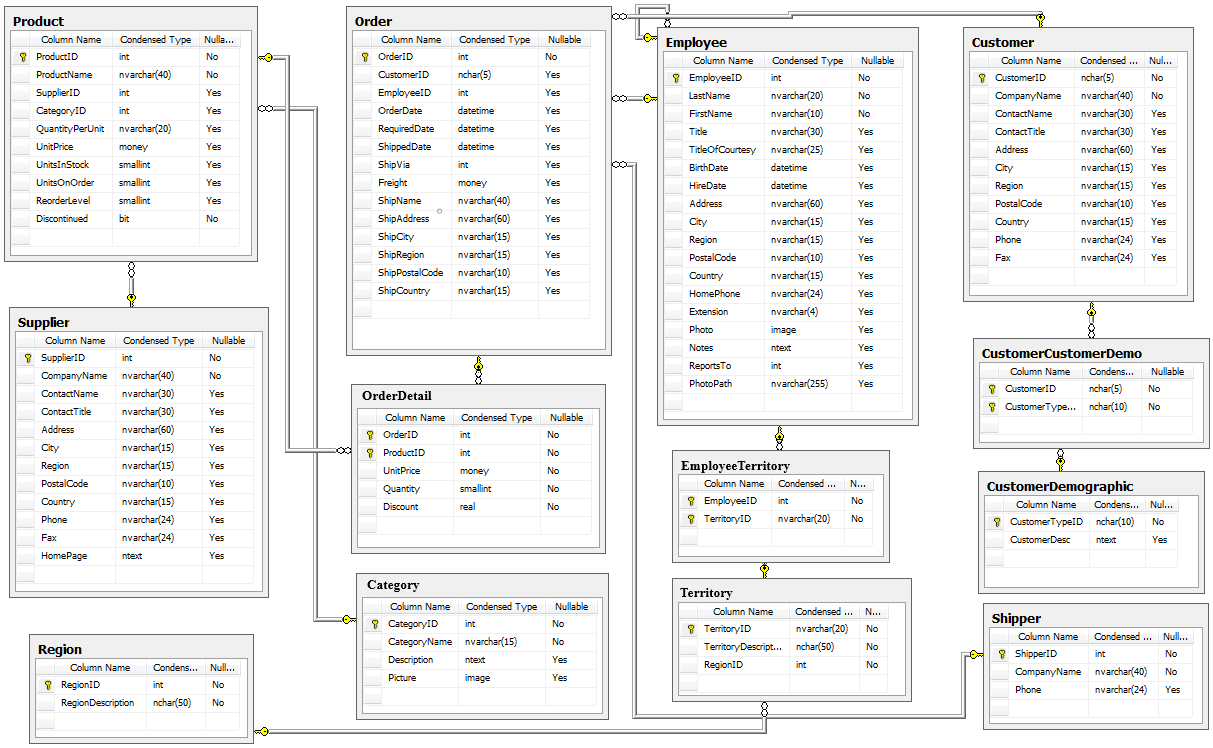

In [2]:
Image("Northwind_ERD_updated.png")

## Q1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Initial data exploration

In [3]:
#SQL query
order_detail = cur.execute('''SELECT * FROM OrderDetail;''').fetchall()

#Creating Pandas DF with fetched data and renaming columns
order_detail_df = pd.DataFrame(order_detail)
order_detail_df.columns = ['orderID/productID','orderID','productID','unit_price','quantity','discount']

#Crating a new column which calculates the total price of each product(quantity x price)
order_detail_df['total_price'] = order_detail_df.apply(lambda row: row.unit_price * row.quantity, axis = 1) 
order_detail_df.head()

,orderID/productID,orderID,productID,unit_price,quantity,discount,total_price
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [4]:
order_detail_df.discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: discount, dtype: int64

We can see that the main discount categories are: 
* 5%
* 10%
* 15%
* 20%
* 25%

Smaller discount rates exist in the database, but are very rare (8 rows out of 2155)
I will only consider the above mentioned discount rates for answering the question to avoid creating unnecessary 
discount categories.

In [5]:
# total sales for different discount rates
sales_per_discount_1 = order_detail_df.groupby('discount').sum()
sales_per_discount_2 = sales_per_discount_1.sort_values(by='quantity',ascending=False, axis=0).head(6)
sales_per_discount_2 = sales_per_discount_2.drop('orderID', axis=1)
sales_per_discount_2 = sales_per_discount_2.drop('productID', axis=1)
sales_per_discount_2 = sales_per_discount_2.drop('unit_price', axis=1)
sales_per_discount_2

,quantity,total_price
discount,,
0.00,28599,750698.61
0.05,5182,155386.71
0.15,4456,102948.44
0.10,4366,101665.71
0.20,4351,111476.38
0.25,4349,131918.09


This table shows us the main discount categories, number of total products sold and the total price.
28599 products were sold without any discount.
Between 4349 and 5182 products were sold per each discount category - total of 22704.

### Preparing variables for hypotheses testing

In [6]:
#Fetching quantity of productd sold for each discount category
#discount_0 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.0;''').fetchall()
#discount_5 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.05;''').fetchall()
#discount_10 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.1;''').fetchall()
#discount_15 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.15;''').fetchall()
#discount_20 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.2;''').fetchall()
#discount_25 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.25;''').fetchall()

#Removing outliers (quantities higher than 100)
discount_0 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.0 and quantity <100;''').fetchall()
discount_5 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.05 and quantity <100;''').fetchall()
discount_10 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.1 and quantity <100;''').fetchall()
discount_15 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.15 and quantity <100;''').fetchall()
discount_20 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.2 and quantity <100;''').fetchall()
discount_25 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.25 and quantity <100;''').fetchall()

#This query resulted in a list of tuples. This function transforms there variables into lists.
def tuple_to_list(item):
    results = []
    for t in item: 
        for x in t: 
            results.append(x) 
    return results

disc_0 = tuple_to_list(discount_0)
disc_5 = tuple_to_list(discount_5)
disc_10 = tuple_to_list(discount_10)
disc_15 = tuple_to_list(discount_15)
disc_20 = tuple_to_list(discount_20)
disc_25 = tuple_to_list(discount_25)

#These two variable are arrays for products sold with some discount(includes all discount categories) and without
#any discount
no_discount = np.array(disc_0)
some_discount = np.array(disc_5 + disc_10 + disc_15 + disc_20 + disc_25)


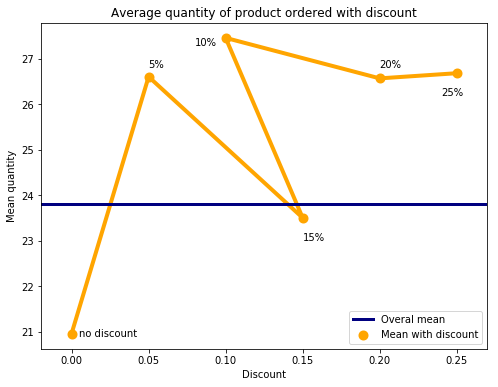

In [33]:
def mean(data):
    average = sum(data)/len(data)
    return average

y = [mean(disc_0),mean(disc_5),mean(disc_10),mean(disc_15),mean(disc_20),mean(disc_25)]
x = list(sales_per_discount_2.index)

plt.figure(figsize=(8,6))
plt.scatter(x, y, color='orange', lw=4,label='Mean with discount')
plt.plot(x, y, color='orange', lw=4,zorder=2)
plt.title('Average quantity of product ordered with discount')
plt.text(0.005,20.9,'no discount')
plt.text(0.05,26.8,'5%')
plt.text(0.08,27.3,'10%')
plt.text(0.15,23,'15%')
plt.text(0.20,26.8,'20%')
plt.text(0.24,26.2,'25%')
plt.axhline(y=order_detail_df.quantity.mean(),label='Overal mean',color='navy',lw=3)
plt.xlabel('Discount')
plt.ylabel('Mean quantity')
plt.legend(loc=4)
plt.show()


### Defining the hypothesis

**Ho: Discount does not increase the number of products sold.**

**H1: Discount does have a statistically significant effect on the increase of the number of products sold.**
   
**$\alpha$: 0.05**

I will perform a 1-sided test

Let's treat no_discount as the control group and some_discount as the experimental group

### Welch's T-Test

In [8]:
fs.p_value_welch_ttest(no_discount, some_discount, two_sided=False)

1.1288081580573817e-11

**Result: 1.1288081580573817e-11**

This very small p-value indicates that there is a statistically significant effect of discount on the quantity of products sold. 

### Effect size

In [9]:
#This function calculates Cohen's D - the difference between two means, measured in standard deviations.

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d

Cohen_d(some_discount,no_discount) #first experimental group, second is control group

0.3116249688964361

**Result: 0.31 - small positive effect.**
A positive effect size indicates that the effect increases the mean.
This means that the discount has a small positive effect on the number of products ordered.

### Some notes on F-one-way test

If the null hypothesis is true, you expect F to have a value close to 1.0 most of the time. A large F ratio means that the variation among group means is more than you'd expect to see by chance. You'll see a large F ratio both when the null hypothesis is wrong (the data are not sampled from populations with the same mean) and when random sampling happened to end up with large values in some groups and small values in others.

The P value is determined from the F ratio and the two values for degrees of freedom shown in the ANOVA table. 

In [10]:
#Testing some_discount and no_discount with F-test
scipy.stats.f_oneway(some_discount,no_discount)

#result: pvalue: 1.7401995278126147e-11 - this further confirms that the means are significantly different

F_onewayResult(statistic=48.79747291506124, pvalue=3.783665239908393e-12)

In [11]:
scipy.stats.f_oneway(no_discount, disc_5, disc_10, disc_15, disc_20, disc_25)

F_onewayResult(statistic=10.903856393918444, pvalue=2.2315034433456942e-10)

## Which level of discount is the most significant?

### Let's perform a F-one-way test on different discount levels

In [12]:
discounts = [disc_5, disc_10, disc_15, disc_20, disc_25]

for item in discounts:
    results = scipy.stats.f_oneway(no_discount,item)
    print('This is the F-statistic and p-value for no_discount and separate discount variables:')
    print(results[1])

This is the F-statistic and p-value for no_discount and separate discount variables:
9.425051748876486e-06
This is the F-statistic and p-value for no_discount and separate discount variables:
0.04678929322981762
This is the F-statistic and p-value for no_discount and separate discount variables:
1.85884574000059e-06
This is the F-statistic and p-value for no_discount and separate discount variables:
2.423739726978939e-05
This is the F-statistic and p-value for no_discount and separate discount variables:
2.2972611265306668e-05


All of these p-values are very small, which suggests that all separate discount levels differs significanly from number of product sold without any discount.

In [13]:
for item in discounts:
    item = np.array(item)
    results = fs.p_value_welch_ttest(no_discount, item, two_sided=False)
    print('This is the p-value for no_discount and separate discount variables:')
    print(results)

This is the p-value for no_discount and separate discount variables:
0.00011015097977618016
This is the p-value for no_discount and separate discount variables:
0.03140764110408012
This is the p-value for no_discount and separate discount variables:
4.2947873018173155e-05
This is the p-value for no_discount and separate discount variables:
0.00010702250945293645
This is the p-value for no_discount and separate discount variables:
5.217000575719055e-05


All of these p-values are very small, which suggests there is a significant difference between their means and the mean of the no_discount variable.

Which discount level has the biggest effect size?

In [14]:
for item in discounts:
    item = np.array(item)
    results = Cohen_d(item,no_discount)
    print('This is effect size for no_discount and separate discount variables:')
    print(results)

This is effect size for no_discount and separate discount variables:
0.35196133789659617
This is effect size for no_discount and separate discount variables:
0.16235556161327822
This is effect size for no_discount and separate discount variables:
0.40701280436876425
This is effect size for no_discount and separate discount variables:
0.35499791035177525
This is effect size for no_discount and separate discount variables:
0.3653568580130326


These results indicate that the discount rates with the biggest effect size are (in descending order):
* 15%
* 25%
* 20%
* 5%

### What does a Cohen's D of 0.4  mean?

* with a Cohen's d of 0.4, 66 % of the treatment group will be above the mean of the control group (Cohen's U3)
* 84 % of the two groups will overlap
* there is a 61 % chance that a person picked at random from the treatment group will have a higher score than a person picked at random from the control group (probability of superiority).

NEXT STEP: Calculating power - I know alpha, effect size and sample size